In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from changepoint_online import NPFocus
from mmdew.mmdew import MMDEW
from mmdew.fast_rbf_kernel import est_gamma
import pandas as pd

In [2]:
rng = np.random.default_rng()

In [3]:
d=20

In [4]:
pre_change = rng.multivariate_normal(mean=[0]*d, cov=np.eye(d),size=1000)
gamma = est_gamma(pre_change)

In [8]:
change_at = 64

# Cov change

In [15]:
statistics = []
for _ in tqdm(range(20)):
    #pre_change -= np.mean(pre_change, axis=0)
    #pre_change /= np.std(pre_change)  
    pre_change = rng.multivariate_normal(mean=[0]*d, cov=np.eye(d),size=change_at) # match mean and variance
    post_change = rng.multivariate_normal(mean=[0]*d, cov=np.ones((d,d)),size=100) #+ rng.normal(scale=0.1,size=(change_at,d))

    data = np.concatenate((pre_change,post_change))    
    gamma = est_gamma(pre_change)
    mmdew_detector = MMDEW(gamma=gamma,min_elements_per_window=1)
    for elem in data:
        mmdew_detector.insert(elem.reshape(1,-1))
    statistics += [mmdew_detector.stats[0:]] # the first few have large variance

100%|███████████████████████████████████████████| 20/20 [00:02<00:00,  8.11it/s]


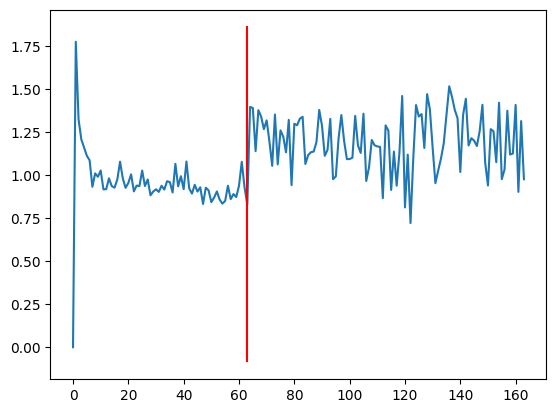

In [16]:
stats = np.max(np.array(statistics),axis=0)

plt.plot(stats)
ymin, ymax = plt.ylim()
plt.vlines(x=change_at-0-1,ymin=ymin,ymax=ymax,colors=["red"]) # -1 due to being zero-based

In [8]:
cov = pd.DataFrame(stats, columns=["test_stat"])
cov["algorithm"] = "MMDEW"
cov["experiment"] = "Covariance shift"

In [9]:
cov

,test_stat,algorithm,experiment
0,0.000000,MMDEW,Covariance shift
1,1.434178,MMDEW,Covariance shift
2,1.289996,MMDEW,Covariance shift
3,1.166558,MMDEW,Covariance shift
4,1.292990,MMDEW,Covariance shift
...,...,...,...
595,0.903789,MMDEW,Covariance shift
596,1.033374,MMDEW,Covariance shift
597,1.218989,MMDEW,Covariance shift
598,1.368381,MMDEW,Covariance shift


# Mean change

In [10]:
statistics = []
for _ in tqdm(range(20)):
    pre_change = rng.multivariate_normal(mean=[0]*d, cov=np.eye(d),size=change_at)
    post_change = rng.multivariate_normal(mean=[1]*d, cov=np.eye(d),size=100)    
    data = np.concatenate((pre_change,post_change))    
    
    mmdew_detector = MMDEW(gamma=gamma,min_elements_per_window=1)
    for elem in data:
        mmdew_detector.insert(elem.reshape(1,-1))
    statistics += [mmdew_detector.stats[0:]] # the first few have large variance

100%|███████████████████████████████████████████| 20/20 [00:09<00:00,  2.21it/s]


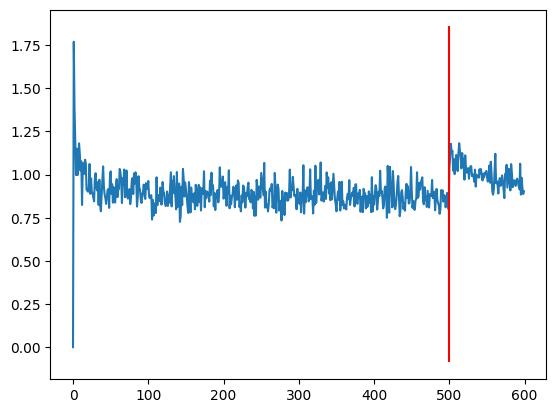

In [11]:
stats = np.max(np.array(statistics),axis=0)

plt.plot(stats)
ymin, ymax = plt.ylim()
plt.vlines(x=change_at-0-1,ymin=ymin,ymax=ymax,colors=["red"]) # -1 due to being zero-based

In [12]:
mean = pd.DataFrame(stats, columns=["test_stat"])
mean["algorithm"] = "MMDEW"
mean["experiment"] = "Mean shift"

In [13]:
df = pd.concat((cov,mean))

In [14]:
df.to_csv("results/mmdew-univariate.csv")